In [1]:
include("../src/coherent_vertex_new.jl")
include("../src/partial_coherent_vertex.jl")
using .coherent_vertex_new

using .partial_coherent_vertex

# use the following packages for the computation 
using JLD2, DelimitedFiles, Memoize, BenchmarkTools, Plots

In [2]:
# face normal vectors for an equilateral tetrahedron
nn= [[0.0, 0.0, 1.0], [0.0, 2sqrt(2)/3, -1/3], 
    [sqrt(2/3), -sqrt(2)/3, -1/3], 
    [-sqrt(2/3), -sqrt(2)/3, -1/3]];

In [3]:
function cohn_vertex(i)
    cohn_vertex1(i*ones(10),[nn,nn,nn,nn,nn])
end


cohn_vertex (generic function with 1 method)

In [4]:
function pat_cohn_vertex2(i)
    partial_cohn_vertex2(i*ones(10),[nn,nn,nn])
end


pat_cohn_vertex2 (generic function with 1 method)

In [5]:
pat_cohn_vertex2(2)

5×5 Matrix{ComplexF64}:
  5.23261e-6+3.39459e-5im  …  -1.69086e-5+9.02062e-6im
  1.27232e-6+2.18678e-5im      5.62035e-6-1.00444e-5im
 -2.25303e-6+1.02748e-5im      2.28462e-6+7.2254e-6im
 -2.79382e-7+5.52792e-6im     -2.75228e-6-2.33806e-6im
 -1.69086e-5+9.02062e-6im      6.99085e-7+4.57885e-7im

In [17]:
@time cohn_vertex(20)

 12.629179 seconds (1.19 M allocations: 68.932 MiB, 0.06% gc time)


-5.6733132610435176e-12 - 9.826466815382416e-12im

In [22]:
@time cohn_vertex1(20*ones(10),[nn,nn,nn,nn,nn])

 12.524253 seconds (1.19 M allocations: 68.932 MiB, 0.07% gc time)


-5.6733132610435176e-12 - 9.826466815382416e-12im

In [23]:
xx = 0:0.5:30
@time camp = [i^6*cohn_vertex(i) for i in xx]; 

  6.148252 seconds (61.32 M allocations: 3.794 GiB, 23.00% gc time, 0.32% compilation time)


In [24]:
ramp=[-(-1+0im)^0k*exp(-im*angle(camp[3])*k)*camp[Int(2k+1)] for k in xx];

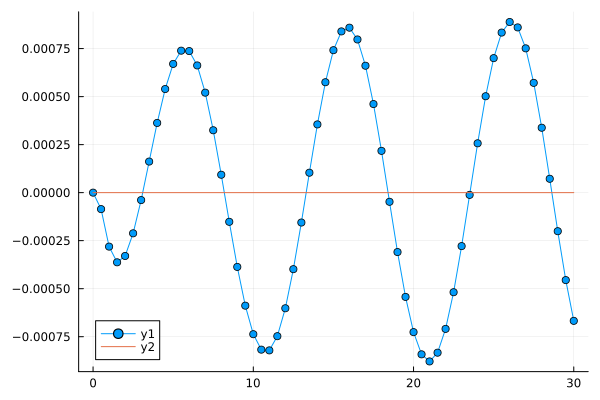

In [25]:
plot(xx,real(ramp),m=:c)
plot!(xx,imag(ramp))

In [26]:
include("../src/su2functions.jl")
using .su2functions
using Tullio

In [44]:
function ccohnX_vertex(x,jays,vcs)
    #note the order of the spins, 1,2,3,4,5 labels the edges (tetrahedron)
    # the labels are equivalent to the bar notation where 1,2,3,4,5 label vertices.. 
    j12, j13, j14, j15, j23, j24, j25, j34, j35, j45 = jays

    #the groups of 4j intertwiner ranges must be consistent with the spin assignments .. 
    #clockwise order for all intertwiners according to graph of vertex
    I1,I2,I3,I4,I5 = intw_range(j12 ,j13 ,j14 ,j15), intw_range(j23, j24, j25, j12), intw_range(j34,j35, j13, j23),
    intw_range(j45, j14, j24, j34), intw_range(j15, j25, j35, j45)

    #coherent 6j matrices
    f6j12 = coherent_intw6j_matrix(vcs[1],(I1,I2),j25,x,j13,j12)

    f6j23 = coherent_intw6j_matrix(vcs[2],(I2,I3),j13,x,j24,j23)

    f6j34 = coherent_intw6j_matrix(vcs[3],(I3,I4),j24,x,j35,j34)

    f6j45 = coherent_intw6j_matrix(vcs[4],(I4,I5),j35,x,j14,j45)

    f6j51 = coherent_intw6j_matrix(vcs[5],(I5,I1),j14,x,j25,j15)

    # compute trace of matrix multiplications for the intertwiners 
    return @tullio S = f6j12[i,j] * f6j23[j,k] * f6j34[k,l] * f6j45[l,m] * f6j51[m,i]
    #return sum( transpose(f6j12) .* (f6j23 * f6j34 * f6j45 * f6j51) )
end

ccohnX_vertex (generic function with 1 method)

In [45]:
function ccohn_vertex1(jays,nvs)
    j12,j13,j14,j15,j23,j24,j25,j34,j35,j45 = jays
   # The order of the spins are the same as the order of the unit normal vectors as inputs
    jjs = (j12,j13,j14,j15),(j23,j24,j25,j12),(j34,j35,j13,j23),(j45,j14,j24,j34),(j15,j25,j35,j45)

    # compute the coherent {4j} vectors for all 5 boundary edges 
    vcs = Dict()
    for i in 1:5 
        vcs[i] = vector_coherent4jPh(jjs[i],nvs[i])
    end
    
    sol = 0.0im 

    # range of values for the virtual spin 
    @simd for x in virtualx_range(jays)
        sol += (-1.0+0.0im)^(sum(jays))*(dim_j(x))*cohnX_vertex(x,jays,vcs)
    end
    return sol
end


ccohn_vertex1 (generic function with 1 method)

In [46]:
function ccohn_vertex(i)
    ccohn_vertex1(i*ones(10),[nn,nn,nn,nn,nn])
end


ccohn_vertex (generic function with 1 method)

In [47]:
@time ccohn_vertex(1)

  0.023906 seconds (24.10 k allocations: 1.578 MiB, 95.82% compilation time)


0.00014049850626253284 - 0.00024335055123424047im

In [50]:
xx = 0:0.5:30
@time ccamp = [i^6*ccohn_vertex(i) for i in xx]; 

  5.472937 seconds (61.32 M allocations: 3.794 GiB, 12.01% gc time, 0.34% compilation time)


In [51]:
rramp=[-(-1+0im)^0k*exp(-im*angle(ccamp[3])*k)*ccamp[Int(2k+1)] for k in xx];

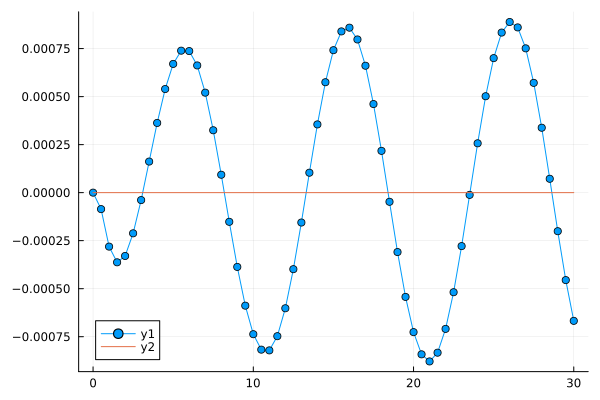

In [52]:
plot(xx,real(rramp),m=:c)
plot!(xx,imag(rramp))